# CS457 - Lab 6

## 1. Download the MNIST Dataset

In [1]:
#Import the libraries
import torch
from torch import nn, optim
from torchsummary import summary
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = MNIST(root='.', train=False, download=True, transform=transform)

## 2.1 Introduce the MNIST Dataset

In [5]:
# Display information about the MNIST dataset
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print(f"Image size (channels, height, width): {train_dataset[0][0].shape }")
print(f"Number of classes: 10")

Number of training images: 60000
Number of test images: 10000
Image size (channels, height, width): torch.Size([1, 28, 28])
Number of classes: 10


## 2.2 Create a Dataset and DataLoader

In [7]:
batchSize = 32
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

# 2.3 Preprocess the Data

In [9]:
# Define Image Augmentations
data_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor()
])

# Prepare the augmented dataset and loader
train_dataset_aug = MNIST(root='.', train=True, download=True, transform=data_transforms)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batchSize, shuffle=True)

# Prepare a combined dataset that is the original plus additional augmented images
train_dataset_combined = ConcatDataset([train_dataset, train_dataset_aug])
train_loader_combined = DataLoader(train_dataset_combined, batch_size=batchSize, shuffle=True)

# The combined dataset is twice as large as the original dataset because it contains
# all of the original images plus all of the augmented images.
print(f"Length of combined dataset: {len(train_dataset_combined)}")

Length of combined dataset: 120000


# 2.4 Visualize the Processed Data

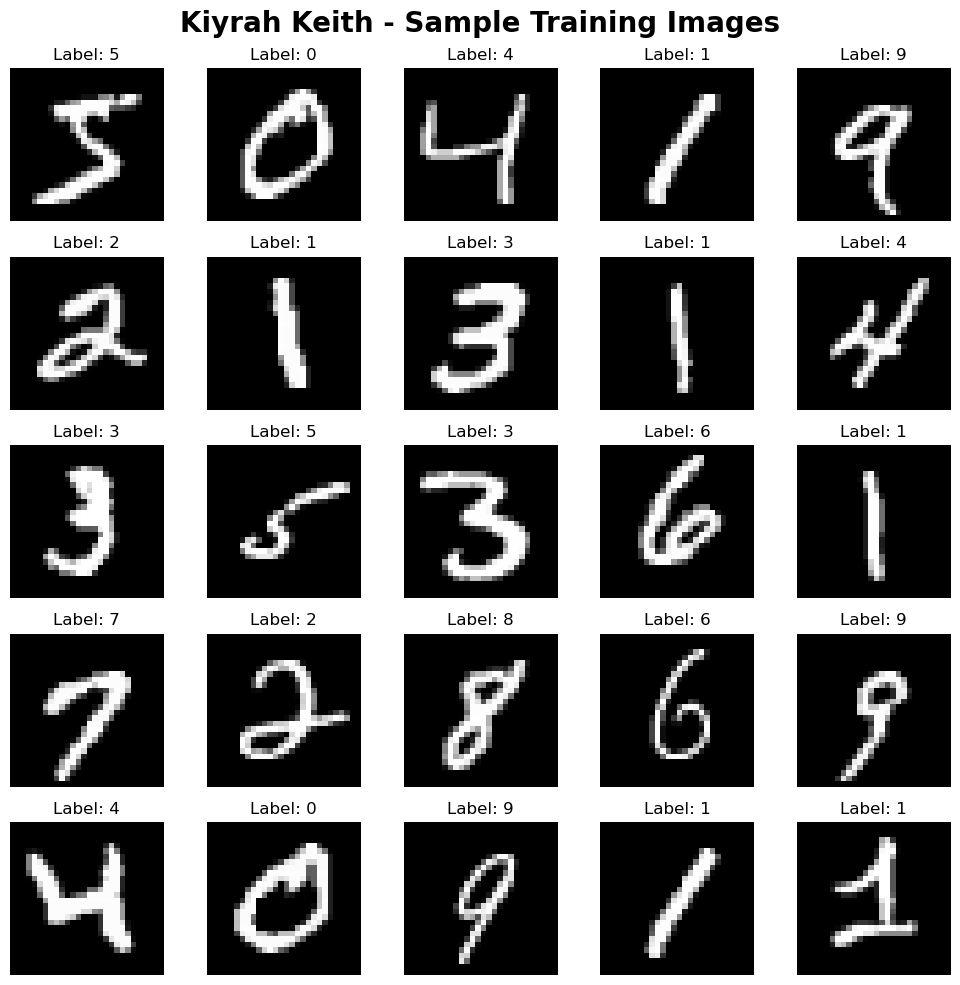

In [194]:
images = []
labels = []

# Loop to collect the images and labels for plotting
for i in range(25):
    image, label = train_dataset[i]
    images.append(image)
    labels.append(label)

# Create a grid of images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # 5x5 grid of images
axes = axes.flatten()
plt.suptitle('Kiyrah Keith - Sample Training Images', fontsize=20, fontweight='bold')

for i in range(25):
    # Convert the tensor image back to a numpy array for plotting
    image_np = images[i].numpy().squeeze()  # Remove the channel dimension
    label = labels[i]
    
    # Plot the image
    axes[i].imshow(image_np, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')  # Turn off the axis

plt.tight_layout()  # Adjust the layout to avoid overlap
plt.show()

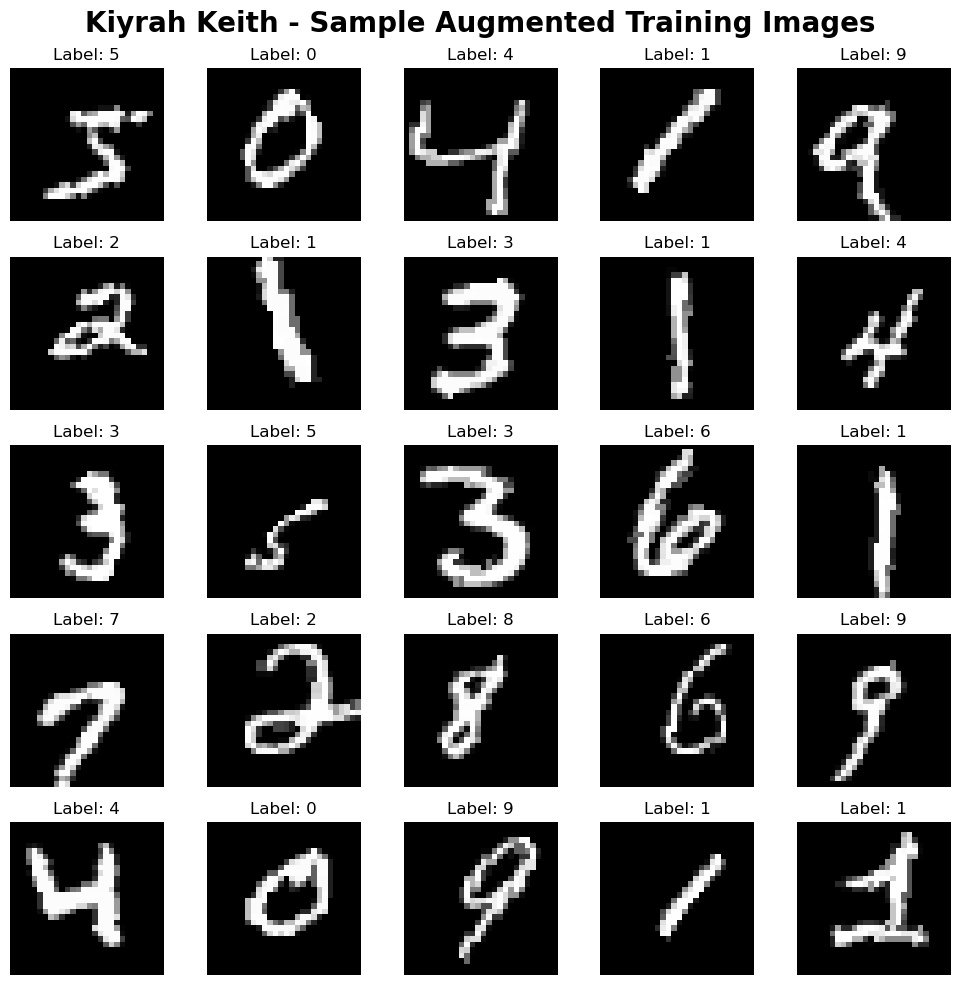

In [11]:
# Show the augmented training set
images = []
labels = []

# Loop to collect the images and labels for plotting
for i in range(25):
    image, label = train_dataset_aug[i]
    images.append(image)
    labels.append(label)

# Create a grid of images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # 5x5 grid of images
axes = axes.flatten()
plt.suptitle('Kiyrah Keith - Sample Augmented Training Images', fontsize=20, fontweight='bold')

for i in range(25):
    # Convert the tensor image back to a numpy array for plotting
    image_np = images[i].numpy().squeeze()  # Remove the channel dimension
    label = labels[i]
    
    # Plot the image
    axes[i].imshow(image_np, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')  # Turn off the axis

plt.tight_layout()  # Adjust the layout to avoid overlap
plt.show()

# 3.1 Define the Model Structure

In [17]:
class Classifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        size_after_conv1 = (28 - 5 + 1) // 2  # Starting size of 28 pixels, Kernel size 5x5, then pool 2x2
        size_after_conv2 = (size_after_conv1 - 3 + 1) // 3  # Kernel size 3x3, then pool 2x2

        self.main = nn.Sequential(
            # First convolution
            nn.Conv2d(input_size, hidden_size, (5, 5)), # Kernel size of 5x5
            nn.ReLU(),
            nn.MaxPool2d((2,2)), # Reduce dimensions by half

            # Second convolution
            nn.Conv2d(hidden_size, hidden_size//2, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((3,3)), # Reduce by a factor of 3
            
            nn.Flatten(), # Convert to 1d vector
            nn.Linear((size_after_conv1 * size_after_conv2)//2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size) # Second fully-connected layer, converts neurons to final output size
        )

    def forward(self, x):
        out = self.main(x)
        return out

# 3.2 Set Up the Trainer

In [13]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    # You may review the ipynb file from Week 6

    # Your code
    train_loss, valid_loss, valid_accuracy = [], [], []
    actual_labels, predict_labels = [], []
    for epoch in range(epochs):
        losses = 0
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_acc = 0

        model.train()
        for X, y in trainloader:
            optimizer.zero_grad()        # Clear gradients w.r.t. parameters
            y_hat = model(X)      # Forward pass to get output
            loss = criterion(y_hat, y)        # Calculate loss
            loss.backward()         # Getting gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()       # Add loss for this batch to running total

        train_loss.append(train_batch_loss / len(trainloader))
        # Validation
        
        model.eval() # Set the model to evaluation mode (disables dropout/batchnorm layers if any)
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                y_hat = model(X) # Forward pass: compute predictions for validation set
                loss = criterion(y_hat, y) # Compute validation loss
                
                valid_batch_loss += loss.item() # Accumulate validation batch loss
                _, predicted = torch.max(y_hat, 1)
                valid_batch_acc += (predicted == y).type(torch.float32).mean().item() # Compute validation accuracy: compare predicted labels to actual labels

                # Store the actual vs predicted labels so that these can be plotted later
                if epoch == epochs-1: # Only save the final batch of predictions
                    actual_labels.extend(y.view(-1).tolist())
                    predict_labels.extend(predicted.view(-1).tolist())
        valid_loss.append(valid_batch_loss / len(validloader)) # Compute average validation loss for this epoch
        valid_accuracy.append(valid_batch_acc / len(validloader))  # Compute average validation accuracy for this epoch
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy,
              "actual_labels": actual_labels,
              "predict_labels": predict_labels}
    return results 

# 3.3 Summarize Your Model

In [15]:
# Build the model with the following parameters
# 1 input layer (because images have one channel - black and white)
# 4 hidden layers
# 10 output layers (because the number of classes in 10)
model = Classifier(1, 4, 10)
summary(model, (1, 28, 28))

NameError: name 'Classifier' is not defined

# 3.4 Train Your Model

In [200]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss function used for categorical classification
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

results = trainer(model, criterion, optimizer, train_loader, test_loader, epochs=10)

Epoch 1: Train Loss: 1.191. Valid Loss: 0.696. Valid Accuracy: 0.77.
Epoch 2: Train Loss: 0.631. Valid Loss: 0.548. Valid Accuracy: 0.82.
Epoch 3: Train Loss: 0.532. Valid Loss: 0.467. Valid Accuracy: 0.85.
Epoch 4: Train Loss: 0.480. Valid Loss: 0.431. Valid Accuracy: 0.87.
Epoch 5: Train Loss: 0.448. Valid Loss: 0.404. Valid Accuracy: 0.88.
Epoch 6: Train Loss: 0.426. Valid Loss: 0.387. Valid Accuracy: 0.89.
Epoch 7: Train Loss: 0.410. Valid Loss: 0.370. Valid Accuracy: 0.89.
Epoch 8: Train Loss: 0.398. Valid Loss: 0.366. Valid Accuracy: 0.89.
Epoch 9: Train Loss: 0.389. Valid Loss: 0.363. Valid Accuracy: 0.89.
Epoch 10: Train Loss: 0.381. Valid Loss: 0.355. Valid Accuracy: 0.89.


In [230]:
# Train the model with image augmentations for comparison with the non-augmented dataset
learning_rate = 0.001
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss function used for categorical classification
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

results = trainer(model, criterion, optimizer, train_loader_combined, test_loader, epochs=10)

Epoch 1: Train Loss: 1.345. Valid Loss: 1.230. Valid Accuracy: 0.58.
Epoch 2: Train Loss: 1.316. Valid Loss: 1.212. Valid Accuracy: 0.59.
Epoch 3: Train Loss: 1.307. Valid Loss: 1.198. Valid Accuracy: 0.60.


KeyboardInterrupt: 